In [1]:
import os
import datetime
import pickle
from tabulate import tabulate

import nlp_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

from sklearn.linear_model import LogisticRegression, ElasticNet

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import spacy, nltk

from collections import Counter
from unidecode import unidecode
from string import punctuation, digits

from nltk.stem.porter import PorterStemmer

# INITIALIZATION
DATA_DIR = "./data/"
RESULT_DIR = "./results/"
DATA_CASE_METADATA = "case_metadata.csv"

logger = nlp_utils.Logger("./logs/")
timer = nlp_utils.Timer()

PS = "ps2_"  # Problem set

# ---------------------------------------------------------------------------------------------------------------------------- #
# LOAD DATA
LOAD_DATA = False

if LOAD_DATA:
    df_all = pd.read_pickle(DATA_DIR + PS + "dataframe.pkl")
else:
    df_meta = pd.read_csv(DATA_DIR + DATA_CASE_METADATA)    
    df_cases = pd.read_pickle(DATA_DIR + "task_1_all.pkl").drop(columns=["case_reversed"])

    # LINK DATAFRAMES
    print(str(sorted(set(df_meta["caseid"].values)) == sorted(set(df_cases["caseid"].values))))

    df_all = pd.concat([df_cases.sort_values(by="caseid").set_index('caseid'),
                        df_meta.sort_values(by="caseid").set_index('caseid')],
                        axis=1, join='inner').reset_index()

    df_all.to_pickle(DATA_DIR + PS + "dataframe.pkl")

df_all.head(5)

True


,caseid,year,content,case_reversed,judge_id,year,log_cites
0,X1037H8N,1993,"BECKER, Circuit Judge.\nThis is a petition fo...",1,114.0,1993.0,NaN
1,X10LQ80003,2004,"STRAUB, Circuit Judge.\nDuring his 1997 inaug...",1,2009.0,2002.0,1.386294
2,X118VF6003,2004,"SEYMOUR, Circuit Judge.\nGerald T. Martin and...",0,1871.0,2004.0,1.098612
3,X11UUP8003,2005,"EASTERBROOK, Circuit Judge.\nComplaints filed...",1,579.0,2005.0,3.135494
4,X125RLM003,2005,"LEVAL, Circuit Judge.\nJacob Zedner appeals f...",1,1221.0,2005.0,2.397895


X_train:	(5185, 3000)
y_train:	(5185,)
X_test:	(577, 3000)
y_test:	(577,)
Training class labels.
Data loaded.
Scaled.
Grid search started.
[LibLinear]Grid search finished.
Training started.
[LibLinear]Training finished.
Prediction started.
Prediction finished.
             Training set    Test set
---------  --------------  ----------
Accuracy         0.69296     0.57539
F1               0.749686    0.661134
Recall           0.730616    0.627297
Precision        0.769777    0.69883
Crossvalidation started.
Mean:	0.574173		Std:	0.020474	-	accuracy
Mean:	0.659291		Std:	0.016936	-	f1
Crossvalidation finished.
LogisticRegression(C=1e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False)
LogisticRegression(C=1e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1

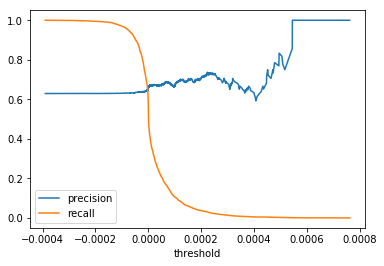

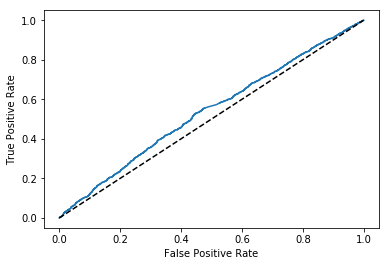

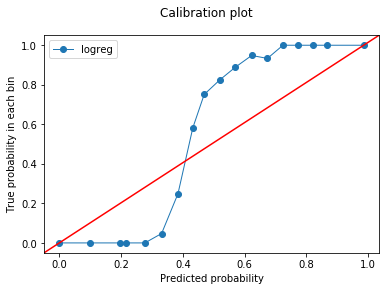

In [2]:
# TASK 1
def train(X_train_file= "./data/X_train.npy",
          X_test_file = "./data/X_test.npy",
          y_train_file = "./data/y_train.npy",
          y_test_file = "./data/y_test.npy",
          impute = (False, ),
          scaling = (False, True),
          power_scaling = False,
          random_search = (False, ),
          training = (True, ),
          cross_validation = (False, ),
          output = False
          ):
    # ---------------------------------------------------------------------------------------------------------------- #
    # Helpers
    
    def load_data():
        
        X_train = np.load(X_train_file)
        X_test = np.load(X_test_file)

        y_train = np.load(y_train_file)
        y_test = np.load(y_test_file)
        
        logger.append("X_train:\t" + str(X_train.shape))
        logger.append("y_train:\t" + str(y_train.shape))
        logger.append("X_test:\t" + str(X_test.shape))
        logger.append("y_test:\t" + str(y_test.shape))
        
        return X_train, y_train, X_test, y_test

    def class_labels(y):
        labels = np.unique(y)
        count = [np.count_nonzero(y == c) for c in labels]
        weights = [c / sum(count) for c in count]
                
        return labels, count, weights

    # ---------------------------------------------------------------------------------------------------------------- #
    # Load data
    X_train, y_train, X_test, y_test = load_data()
    
    logger.append("Training class labels.")
    class_labels, class_count, class_weights = class_labels(y_train)

    logger.append("Data loaded.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Missing values
    if impute[0]:
        imp = SimpleImputer(missing_values=np.nan, strategy=impute[1])
        imp = imp.fit(X_train)
        X_train = imp.transform(X_train)
        X_test = imp.transform(X_test)
        logger.append("Missing values imputed.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Feature scaling
    if scaling[0]:
        scaler = StandardScaler(with_mean=scaling[1])
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        logger.append("Scaled.")

    if power_scaling:
        ptransformer = PowerTransformer()
        ptransformer.fit(X_train)
        X_train = ptransformer.transform(X_train)
        X_test = ptransformer.transform(X_test)
        logger.append("Power scaled.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Training

    if random_search[0]:
        logger.append("Grid search started.")
        cls = random_search[1]["cls"]
        rs = GridSearchCV(cls, param_grid=random_search[1]["param_dist"], 
                          cv=5, n_jobs=-1, scoring="f1")
        rs.fit(X_train, y_train.ravel())
        best_est = rs.best_estimator_
        # logger.append(rs.best_estimator_)
        logger.append("Grid search finished.")
            
    if training[0]:
        if not random_search[0]:
            est = random_search[3]
        else:
            est = best_est

        vc = est

        logger.append("Training started.")
        vc.fit(X_train, y_train.ravel())
        logger.append("Training finished.")

        logger.append("Prediction started.")
        y_train_pred = vc.predict(X_train)
        y_test_pred = vc.predict(X_test)
        logger.append("Prediction finished.")
        
        scores = [
            ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
            ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
            ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
            ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
            ]
        
        logger.append(tabulate(scores, headers=["Training set", "Test set"]))
        
    # ------------------------------------------------------------------------------------------------------------ #
    # Cross validation
    if cross_validation[0]:
        logger.append("Crossvalidation started.")
        score = cross_val_score(vc, X_train, y_train.ravel(), cv=cross_validation[1], scoring=cross_validation[2], n_jobs=-1)
        logger.append("Mean:\t%f\t\tStd:\t%f\t-\t%s" % (score.mean(), score.std(), cross_validation[2]))
        
        score = cross_val_score(vc, X_train, y_train.ravel(), cv=cross_validation[1], scoring=cross_validation[3], n_jobs=-1)
        logger.append("Mean:\t%f\t\tStd:\t%f\t-\t%s" % (score.mean(), score.std(), cross_validation[3]))
        
        logger.append("Crossvalidation finished.")

    # ---------------------------------------------------------------------------------------------------------------- #

    logger.create_log()
    return vc, best_est

# ---------------------------------------------------------------------------------------------------------------------------- #
LOAD_DATA = False
X_train = np.load("./data/X_train.npy")
X_test = np.load("./data/X_test.npy")
y_train = np.load("./data/y_train.npy")
y_test = np.load("./data/y_test.npy")

if LOAD_DATA:
    with open(RESULT_DIR + PS + "task_1_estimator.pkl", "rb") as f:
        estimator, best_est = pickle.load(f)
else:
    param_dist = {
        "param_dist": {
            "penalty": ["l1", "l2"],
            "C": [np.power(10.0, c) for c in range(-7, -3)]
        },
        "cls": LogisticRegression(random_state=0, solver='liblinear', 
                                  n_jobs=-1, verbose=1, max_iter=100, class_weight ="balanced")
    }

    estimator, best_est = train(
          scaling = (True, False),
          power_scaling = False,
          random_search = (True, param_dist, 10,),
          training = (True, param_dist),
          cross_validation = (True, 10, "accuracy", "f1"),
          output = False
          )
    
    with open(RESULT_DIR + PS + "task_1_estimator.pkl", "wb") as f:
        pickle.dump((estimator, best_est), f)
        
logger.append(estimator)
logger.append(best_est)

# PREDICT
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)

scores = [
    ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
]
logger.append(tabulate(scores, headers=["Training set", "Test set"]))

# CONFUSION MATRIX
y_train_cross = cross_val_predict(estimator, X_train, y_train, cv=5, n_jobs=-1)
logger.append(tabulate(confusion_matrix(y_true=y_train, y_pred=y_train_cross, labels=[0, 1]), headers=["0", "1"]))

# PRECISION RECALL CURVE
y_train_cross = cross_val_predict(estimator, X_train, y_train, cv=5, n_jobs=-1, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_cross)

plt.figure("precision_recall")
plt.plot(thresholds, precisions[:-1], label="precision")
plt.plot(thresholds, recalls[:-1], label="recall")
plt.xlabel('threshold')
plt.legend()
plt.show()

# ROC CURVE
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_train_cross)
plt.figure("roc_curve")
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# CALIBRATION PLOT
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

probs = estimator.decision_function(X_train)
logreg_y, logreg_x = calibration_curve(y_train, probs, n_bins=20, normalize=True)

fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

X_train:	(3959, 3000)
y_train:	(3959,)
X_test:	(440, 3000)
y_test:	(440,)
Data loaded.
Scaled.
Training started.
Training finished.
Prediction started.
Prediction finished.
       Training set    Test set
---  --------------  ----------
MSE        0.192951     4.70203
Crossvalidation started.
Mean:	2.654569		Std:	0.368271	-	neg_mean_squared_error
Crossvalidation finished.
ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=100, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)


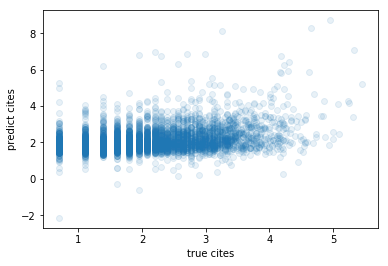

In [3]:
# TASK 2
from sklearn.metrics import mean_squared_error

def train(X_train_file= "./data/X_train.npy",
          X_test_file = "./data/X_test.npy",
          y_train_file = "./data/y_train.npy",
          y_test_file = "./data/y_test.npy",
          impute = (False, ),
          scaling = (False, True),
          power_scaling = False,
          random_search = (False, ),
          training = (True, ),
          cross_validation = (False, ),
          output = False
          ):
    # ---------------------------------------------------------------------------------------------------------------- #
    # Helpers
    
    def load_data():
        
        X_train = np.load(X_train_file)
        X_test = np.load(X_test_file)

        y_train = np.load(y_train_file)
        y_test = np.load(y_test_file)
        
        logger.append("X_train:\t" + str(X_train.shape))
        logger.append("y_train:\t" + str(y_train.shape))
        logger.append("X_test:\t" + str(X_test.shape))
        logger.append("y_test:\t" + str(y_test.shape))
        
        return X_train, y_train, X_test, y_test

    # ---------------------------------------------------------------------------------------------------------------- #
    # Load data
    X_train, y_train, X_test, y_test = load_data()
    logger.append("Data loaded.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Missing values
    if impute[0]:
        imp = SimpleImputer(missing_values=np.nan, strategy=impute[1])
        imp = imp.fit(X_train)
        X_train = imp.transform(X_train)
        X_test = imp.transform(X_test)
        logger.append("Missing values imputed.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Feature scaling
    if scaling[0]:
        scaler = StandardScaler(with_mean=scaling[1])
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        logger.append("Scaled.")

    if power_scaling:
        ptransformer = PowerTransformer()
        ptransformer.fit(X_train)
        X_train = ptransformer.transform(X_train)
        X_test = ptransformer.transform(X_test)
        logger.append("Power scaled.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Training
    if random_search[0]:
        logger.append("Grid search started.")
        cls = random_search[1]["cls"]
        rs = GridSearchCV(cls, param_grid=random_search[1]["param_dist"], 
                          cv=5, n_jobs=-1, scoring="neg_mean_squared_error")
        rs.fit(X_train, y_train.ravel())
        best_est = rs.best_estimator_
        logger.append("Grid search finished.")
            
    if training[0]:
        if not random_search[0]:
            est = random_search[3]
        else:
            est = best_est

        vc = est

        logger.append("Training started.")
        vc.fit(X_train, y_train.ravel())
        logger.append("Training finished.")

        logger.append("Prediction started.")
        y_train_pred = vc.predict(X_train)
        y_test_pred = vc.predict(X_test)
        logger.append("Prediction finished.")
        
        scores = [
            ["MSE", mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
            ]
        
        logger.append(tabulate(scores, headers=["Training set", "Test set"]))
        
    # ------------------------------------------------------------------------------------------------------------ #
    # Cross validation
    if cross_validation[0]:
        logger.append("Crossvalidation started.")
        score = cross_val_score(vc, X_train, y_train.ravel(), cv=cross_validation[1], scoring=cross_validation[2], n_jobs=-1)
        logger.append("Mean:\t%f\t\tStd:\t%f\t-\t%s" % (-score.mean(), score.std(), cross_validation[2]))       
        logger.append("Crossvalidation finished.")

    # ---------------------------------------------------------------------------------------------------------------- #

    logger.create_log()
    return vc

# ---------------------------------------------------------------------------------------------------------------------------- #
LOAD_DATA = False

if LOAD_DATA:
    with open(RESULT_DIR + PS + "task_2_estimator_cites.pkl", "rb") as f:
        estimator_cites = pickle.load(f)
else:
    X = np.load(DATA_DIR + "task_4_X_3000.npy")

    not_nan_idx = np.argwhere(1 - np.isnan(df_all["log_cites"].values)).flatten()

    X = X[not_nan_idx, :]
    y = df_all["log_cites"].values[not_nan_idx]
    
    X_train_cites, X_test_cites, y_train_cites, y_test_cites = train_test_split(X, y, test_size=0.1, shuffle=True, 
                                                                                random_state=42)

    np.save(DATA_DIR + "X_train_cites.npy", X_train_cites)
    np.save(DATA_DIR + "y_train_cites.npy", y_train_cites)
    np.save(DATA_DIR + "X_test_cites.npy", X_test_cites)
    np.save(DATA_DIR + "y_test_cites.npy", y_test_cites)

    np.random.seed(12345)
    param_dist = {
        "param_dist": {
            "alpha": [np.power(10.0, c) for c in range(-6, -2)],
            "l1_ratio": [0.2 * c for c in range(1, 5)]
        },
        "cls": ElasticNet(max_iter=100, random_state=0)
    }

    estimator_cites = train(
          X_train_file= DATA_DIR + "X_train_cites.npy",
          X_test_file = DATA_DIR + "X_test_cites.npy",
          y_train_file = DATA_DIR + "y_train_cites.npy",
          y_test_file = DATA_DIR + "y_test_cites.npy",
          scaling = (True, False),
          power_scaling = False,
          random_search = (False, param_dist, 10, ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=100, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)),
          training = (True, param_dist),
          cross_validation = (True, 10, "neg_mean_squared_error"),
          output = False
          )
    
    with open(RESULT_DIR + PS + "task_2_estimator_cites.pkl", "wb") as f:
        pickle.dump(estimator_cites, f)
        
logger.append(estimator_cites)


y_train_cross_cites = cross_val_predict(estimator_cites, X_train_cites, y_train_cites, cv=10, n_jobs=-1)

plt.figure()
plt.scatter(y_train_cites, y_train_cross_cites, alpha=.1)
plt.xlabel("true cites")
plt.ylabel("predict cites")
plt.show()

In [8]:
# TASK 3
# PASS

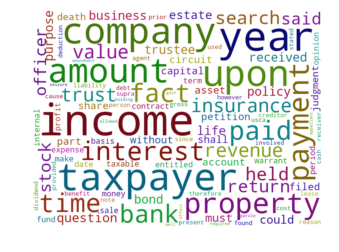

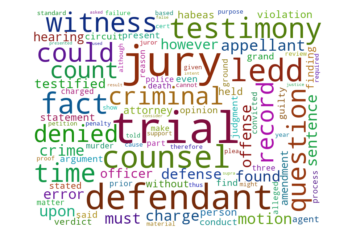

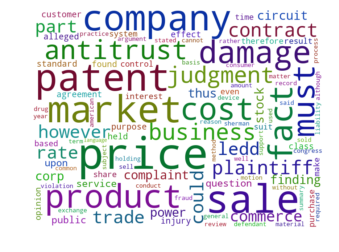

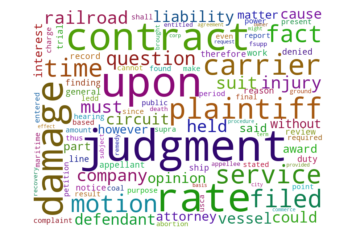

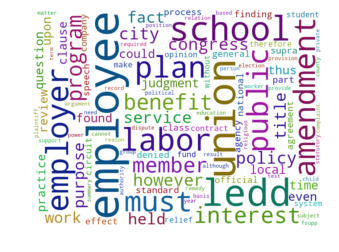

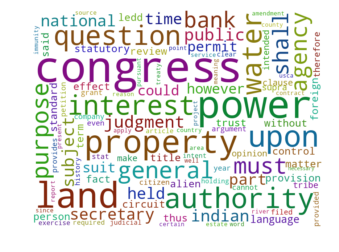

In [4]:
# TASK 4
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud

np.random.seed(12345)
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer() 

newstop = ["state", "court", "district", "judge", "would", "case", "claim", "party", "right", "decision", "section",
           "statute", "evidence", "issue", "whether", "also", "federal", "rule", "action", "first", "supreme", "second",
          "appeal", "order", "united", "made", "loss", "board", "within"]

nlp = spacy.load("en", disable =["ner"])

def clean_document(doc, noun_chunks=False):
    if noun_chunks:
        translator = str.maketrans('','', punctuation)
        doc = doc.translate(translator)
        translator = str.maketrans('', '', digits)
        doc = doc.translate(translator)
        doc = nlp(doc)
        doc = ["_".join(t.text.lower().split()) for t in doc.noun_chunks if len(t.text) > 3 and len(t.text) < 20]
    else:
        translator = str.maketrans('','', punctuation)
        doc = doc.translate(translator)
        translator = str.maketrans('', '', digits)
        doc = doc.translate(translator)


        doc = [i for i in doc.lower().split() if i not in stop and len(i) < 10]
        # doc = [stemmer.stem(t) for t in doc]
        doc = [lemmatizer.lemmatize(t) for t in doc]
        doc = [t for t in doc if t not in newstop]
        doc = [t for t in doc if len(t) > 3]
    
    return doc

def colorfunc(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        maincol = np.random.randint(0,360)
        color = np.random.randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,np.random.randint(65, 75)+ font_size / 7, np.random.randint(35, 45)-font_size / 10)   

doc_clean = [clean_document(doc, False) for doc in df_all["content"]]
random.shuffle(doc_clean)

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
lda = LdaModel(doc_term_matrix, num_topics=6, id2word=dictionary, passes=5)
lda.show_topics(formatted=False)

for _, weights in lda.show_topics(num_topics=-1, num_words=100, formatted=False):
    wordcloud = WordCloud(background_color="white", ranks_only=False, max_font_size=120, color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [5]:
# TASK 5
import keras

X_train = np.load("./data/X_train.npy")
X_test = np.load("./data/X_test.npy")
y_train = np.load("./data/y_train.npy")
y_test = np.load("./data/y_test.npy")

def class_labels(y):
    labels = np.unique(y)
    count = [np.count_nonzero(y == c) for c in labels]
    weights = [c / sum(count) for c in count]
    weights_train = {lab: 1.0/(c / sum(count)) for lab, c in enumerate(count)}
    return weights_train, weights

np.random.seed(12345)

class_weights, weights = class_labels(y_train)
print(class_weights)

print(estimator.coef_.shape) # WITHOUT BIAS

# MODEL AND TRAINING (STANDARD)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=1, input_dim=X_train.shape[1], activation="sigmoid", use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-07), activity_regularizer=keras.regularizers.l2(1e-07)
))
print(model.summary())

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model_info = model.fit(X_train, y_train, epochs=100, validation_split=0.0, verbose=0, class_weight=class_weights)

# PREDICT
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)
scores = [
    ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
]
logger.append("Logistic regression - SKLEARN")
logger.append(tabulate(scores, headers=["Training set", "Test set"]))


y_train_pred = model.predict(X_train) > 0.5
y_test_pred = model.predict(X_test) > 0.5
scores = [
    ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
]
logger.append("Logistic regression - KERAS")
logger.append(tabulate(scores, headers=["Training set", "Test set"]))

logger.append("Class weights - train:\t" + str(weights))
class_weights, weights = class_labels(y_train_pred)
logger.append("Class weights - pred:\t" + str(weights))

# ---------------------------------------------------------------------------------------------------------------------------- #
np.random.seed(12345)
class_weights, weights = class_labels(y_train)

# MODEL AND TRAINING (HIDDEN LAYERS, BATCH NORMALIZATION, DROPOUT)
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, input_dim=X_train.shape[1], activation=None, use_bias=False)) 
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(20, input_dim=20, activation=None, use_bias=False))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1, input_dim=20, activation="sigmoid", use_bias=False))
print(model.summary())

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model_info = model.fit(X_train, y_train, epochs=50, validation_split=0.0, verbose=0, class_weight=class_weights)

# PREDICT
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)
scores = [
    ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
]
logger.append("Logistic regression - SKLEARN")
logger.append(tabulate(scores, headers=["Training set", "Test set"]))


y_train_pred = model.predict(X_train) > 0.5
y_test_pred = model.predict(X_test) > 0.5
scores = [
    ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
    ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
    ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
    ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
]
logger.append("Logistic regression - KERAS")
logger.append(tabulate(scores, headers=["Training set", "Test set"]))

logger.append("Class weights - train:\t" + str(weights))
class_weights, weights = class_labels(y_train_pred)
logger.append("Class weights - pred:\t" + str(weights))

Using TensorFlow backend.


{0: 2.697710718002081, 1: 1.589028501379099}
(1, 3000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3000      
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________
None
Logistic regression - SKLEARN
             Training set    Test set
---------  --------------  ----------
Accuracy         0.639151    0.563258
F1               0.699438    0.647059
Recall           0.667177    0.606299
Precision        0.734976    0.693694
Logistic regression - KERAS
             Training set    Test set
---------  --------------  ----------
Accuracy         0.854388    0.556326
F1               0.877574    0.637394
Recall           0.829298    0.590551
Precision        0.931818    0.692308
Class weights - train:	[0.37068466730954674, 0.6293153326904533]
Class weights - pred:	[0.4399